

# Step 1 – Data loading & first-pass cleaning



In [9]:



# -----------------------------------------------------------
# berlin_crime_trends_2012_2019.ipynb  |  STEP 1 – LOAD & CLEAN
# -----------------------------------------------------------
# 1. Library imports
import pandas as pd
import numpy as np



DATA_PATH = "data/Berlin_crimes.csv"   
df = pd.read_csv(DATA_PATH)

# 4. Quick inspection
print("Raw shape :", df.shape)
display(df.head())
df.info()


df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)


if df['year'].dtype == 'O':
    df['year'] = df['year'].astype(int)


if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
else:
    # assume year & month columns exist
    if {'month', 'day'}.issubset(df.columns):
        df['date'] = pd.to_datetime(
            df[['year', 'month', 'day']]
            .astype(str)
            .agg('-'.join, axis=1),
            errors='coerce'
        )
    elif 'month' in df.columns:
        df['date'] = pd.to_datetime(
            df['year'].astype(str) + '-' + df['month'].astype(str) + '-01',
            errors='coerce'
        )


initial_rows = df.shape[0]
df = df.drop_duplicates()
print(f"Dropped {initial_rows - df.shape[0]} duplicate rows.")


missing = df.isna().mean().mul(100).round(1)
print("Missing values (%):\n", missing[missing > 0])


critical_cols = ['district', 'year']          
df = df.dropna(subset=critical_cols)


num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(0)


df.to_pickle("data/berlin_crime_clean.pkl")
print("Clean dataset saved to data/berlin_crime_clean.pkl")




Raw shape : (1200, 20)


,Year,District,Code,Location,Robbery,Street_robbery,Injury,Agg_assault,Threat,Theft,Car,From_car,Bike,Burglary,Fire,Arson,Damage,Graffiti,Drugs,Local
0,2012,Mitte,10111,Tiergarten Süd,70,46,586,194,118,2263,18,328,120,68,16,4,273,26,171,1032
1,2012,Mitte,10112,Regierungsviertel,65,29,474,123,142,3203,10,307,170,37,10,4,380,124,98,870
2,2012,Mitte,10113,Alexanderplatz,242,136,1541,454,304,8988,81,792,822,275,49,27,1538,522,435,3108
3,2012,Mitte,10114,Brunnenstraße Süd,52,25,254,60,66,1916,86,192,396,131,14,5,428,122,213,752
4,2012,Mitte,10221,Moabit West,130,51,629,185,199,2470,94,410,325,161,42,22,516,64,259,1403


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Year            1200 non-null   int64 
 1   District        1200 non-null   object
 2   Code            1200 non-null   int64 
 3   Location        1200 non-null   object
 4   Robbery         1200 non-null   int64 
 5   Street_robbery  1200 non-null   int64 
 6   Injury          1200 non-null   int64 
 7   Agg_assault     1200 non-null   int64 
 8   Threat          1200 non-null   int64 
 9   Theft           1200 non-null   int64 
 10  Car             1200 non-null   int64 
 11  From_car        1200 non-null   int64 
 12  Bike            1200 non-null   int64 
 13  Burglary        1200 non-null   int64 
 14  Fire            1200 non-null   int64 
 15  Arson           1200 non-null   int64 
 16  Damage          1200 non-null   int64 
 17  Graffiti        1200 non-null   int64 
 18  Drugs   



# Step 2 – Exploratory Data Analysis (EDA)



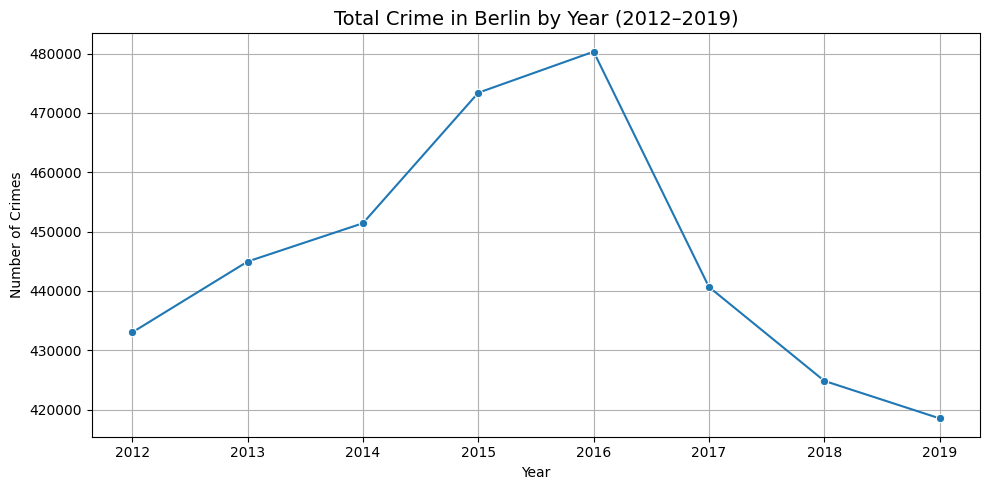

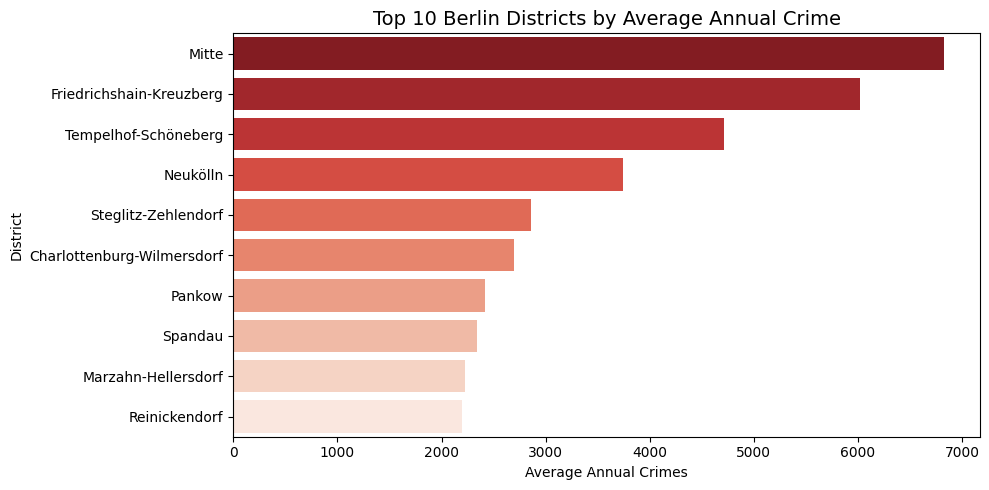

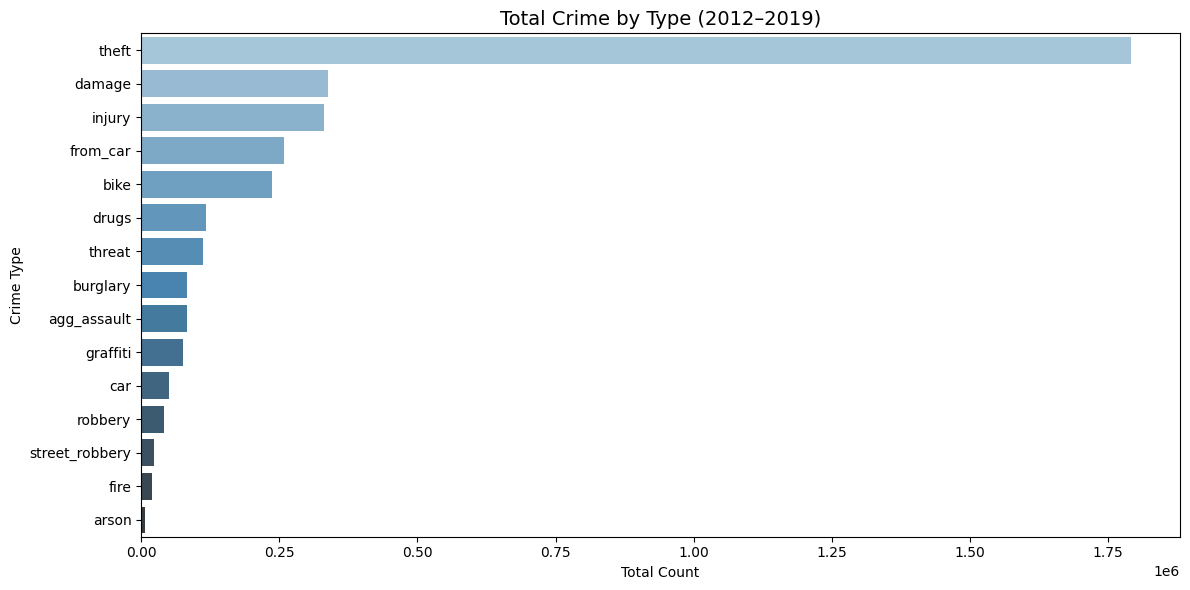

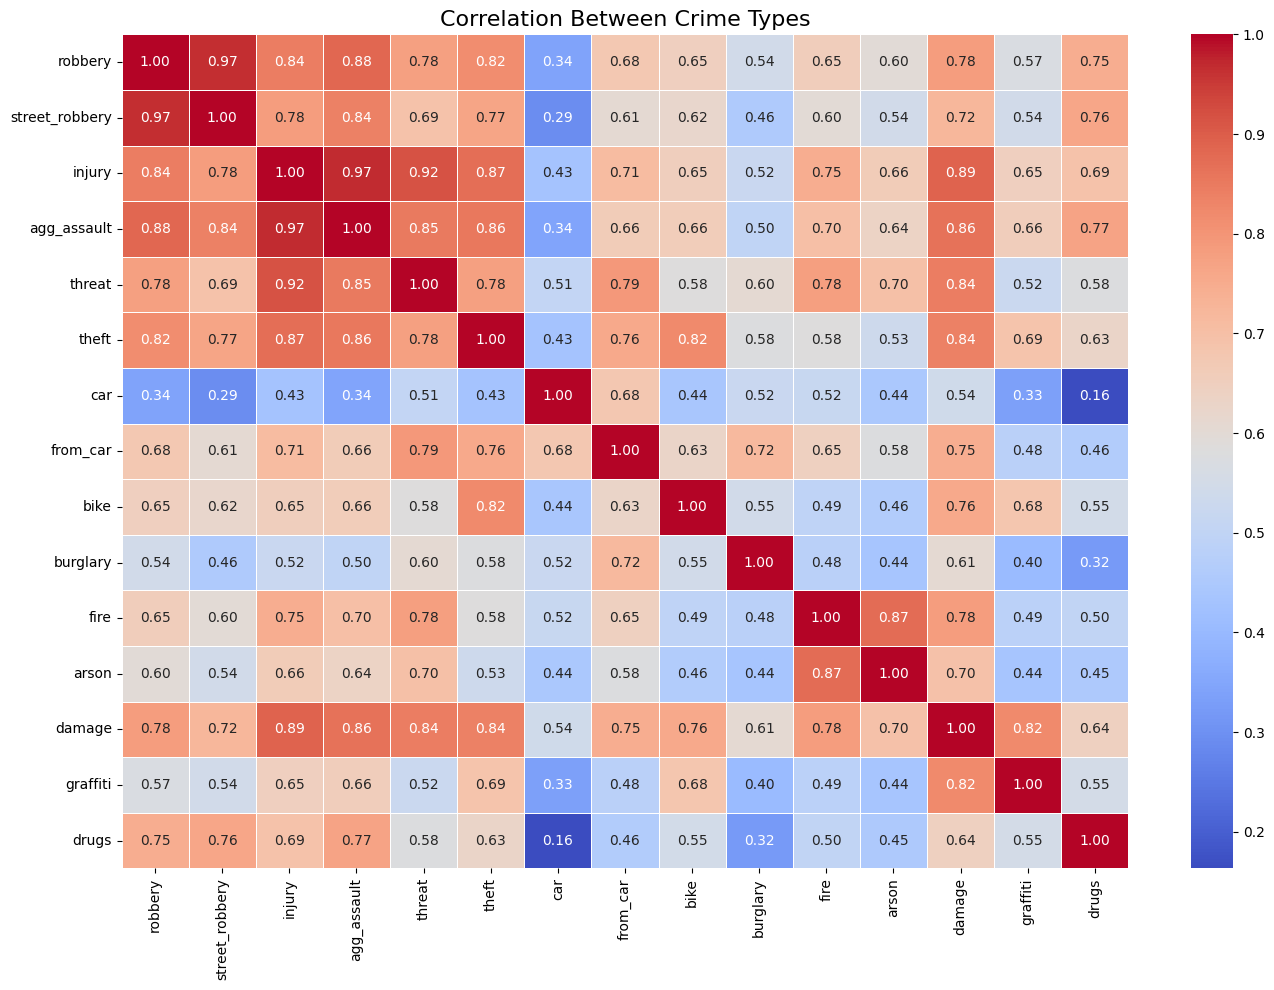

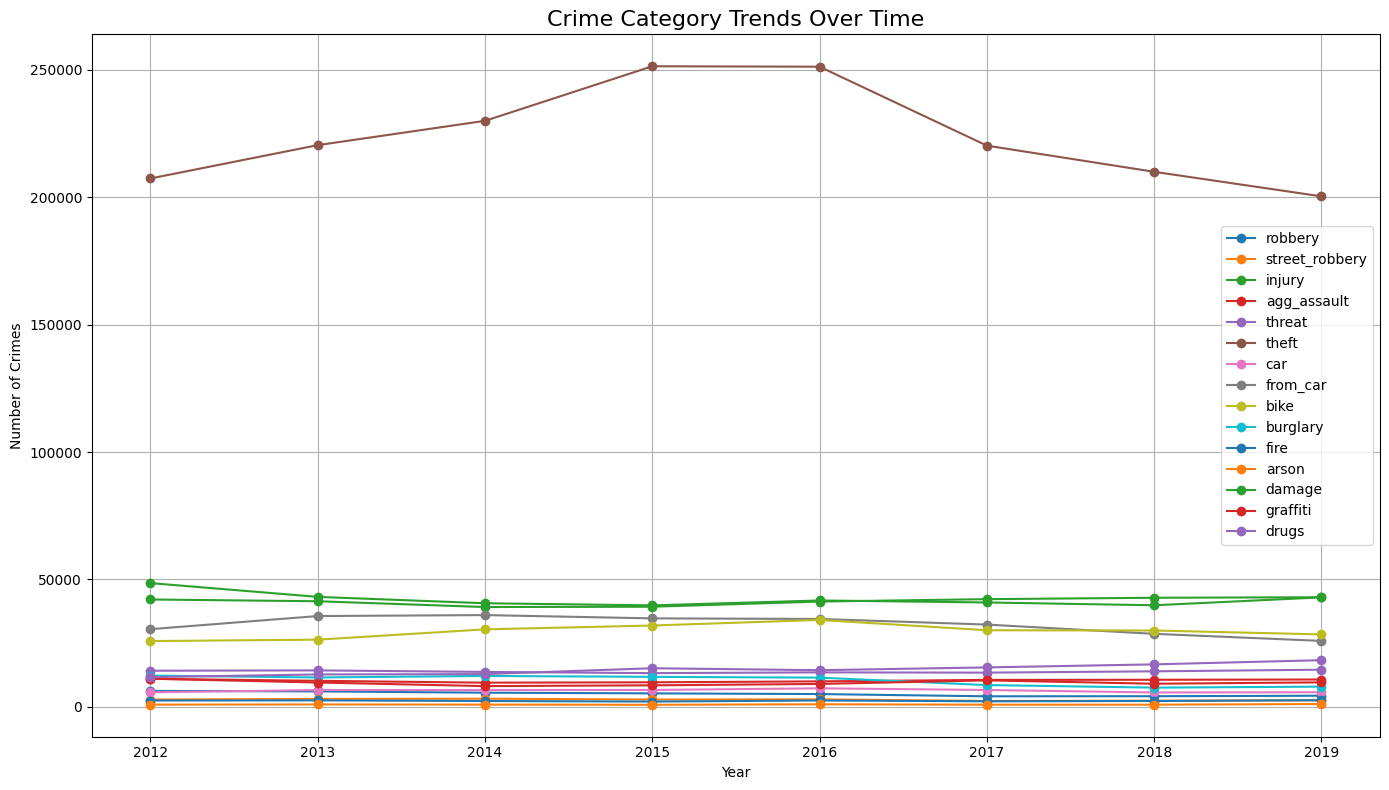

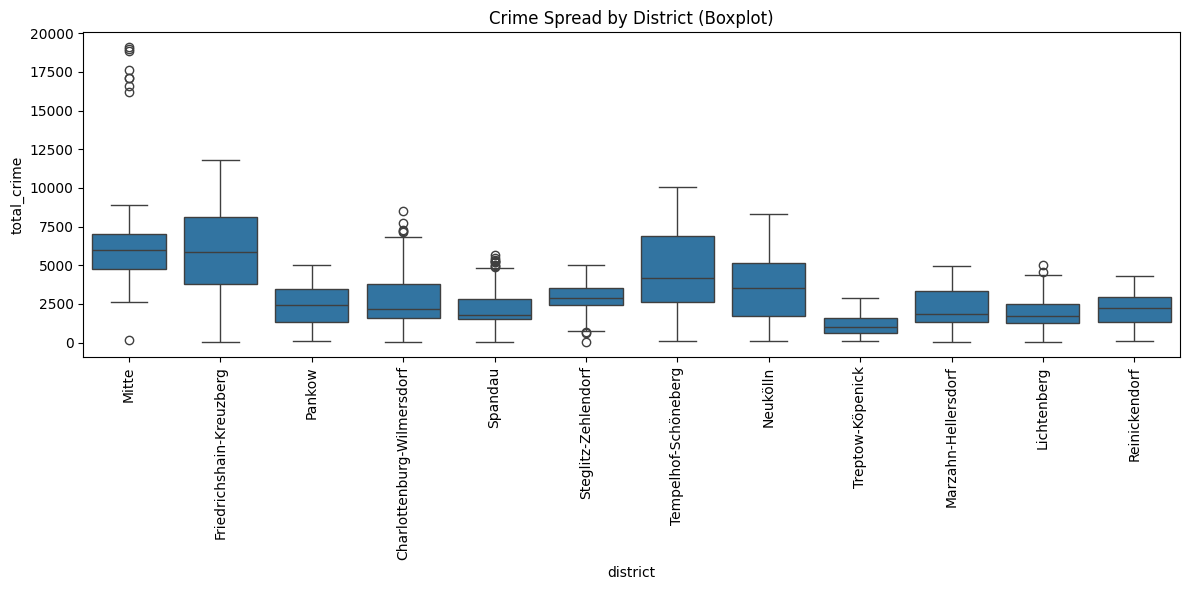

In [10]:



# -----------------------------------------------------------
# STEP 2 – EXPLORATORY DATA ANALYSIS (EDA) - FIXED
# -----------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_pickle("data/berlin_crime_clean.pkl")


crime_categories = df.columns[4:-1]  
df['total_crime'] = df[crime_categories].sum(axis=1)


yearly_total = df.groupby("year")['total_crime'].sum()

plt.figure(figsize=(10, 5))
sns.lineplot(x=yearly_total.index, y=yearly_total.values, marker='o')
plt.title("Total Crime in Berlin by Year (2012–2019)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.grid(True)
plt.tight_layout()
plt.show()


district_avg = df.groupby("district")['total_crime'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=district_avg.values, y=district_avg.index, hue=district_avg.index, palette="Reds_r", legend=False)
plt.title("Top 10 Berlin Districts by Average Annual Crime", fontsize=14)
plt.xlabel("Average Annual Crimes")
plt.ylabel("District")
plt.tight_layout()
plt.show()


total_by_type = df[crime_categories].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=total_by_type.values, y=total_by_type.index, hue=total_by_type.index, palette="Blues_d", legend=False)
plt.title("Total Crime by Type (2012–2019)", fontsize=14)
plt.xlabel("Total Count")
plt.ylabel("Crime Type")
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 10))
corr_matrix = df[crime_categories].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Crime Types", fontsize=16)
plt.tight_layout()
plt.show()


crime_over_time = df.groupby('year')[crime_categories].sum()
crime_over_time.plot(marker='o', figsize=(14, 8))
plt.title("Crime Category Trends Over Time", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='district', y='total_crime')
plt.title("Crime Spread by District (Boxplot)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()







# Step 3: Feature Engineering



In [13]:


# -----------------------------------------------------------
# STEP 3 – FEATURE ENGINEERING
# -----------------------------------------------------------


df = pd.read_pickle("data/berlin_crime_clean.pkl")


crime_columns = df.columns[4:-1]  
df['total_crime'] = df[crime_columns].sum(axis=1)


violent_crimes = ['robbery', 'street_robbery', 'injury', 'agg_assault', 'threat']
property_crimes = ['theft', 'car', 'from_car', 'bike', 'burglary', 'graffiti', 'damage']
fire_crimes = ['fire', 'arson']
drug_crimes = ['drugs']


df['violent_crime'] = df[violent_crimes].sum(axis=1)
df['property_crime'] = df[property_crimes].sum(axis=1)
df['fire_crime'] = df[fire_crimes].sum(axis=1)
df['drug_crime'] = df[drug_crimes].sum(axis=1)


df['pct_violent'] = df['violent_crime'] / df['total_crime']
df['pct_property'] = df['property_crime'] / df['total_crime']
df['pct_drugs'] = df['drug_crime'] / df['total_crime']
df['pct_fire'] = df['fire_crime'] / df['total_crime']


from scipy.stats import zscore

df['z_total_crime'] = df.groupby('year')['total_crime'].transform(zscore)
df['z_violent'] = df.groupby('year')['violent_crime'].transform(zscore)
df['z_property'] = df.groupby('year')['property_crime'].transform(zscore)



agg_df = df.groupby(['year', 'district']).agg({
    'total_crime': 'sum',
    'violent_crime': 'sum',
    'property_crime': 'sum',
    'fire_crime': 'sum',
    'drug_crime': 'sum',
    'pct_violent': 'mean',
    'pct_property': 'mean',
    'pct_drugs': 'mean',
    'pct_fire': 'mean',
    'z_total_crime': 'mean',
    'z_violent': 'mean',
    'z_property': 'mean'
}).reset_index()


print("Engineered dataset shape:", agg_df.shape)
display(agg_df.head())


agg_df.to_csv("data/berlin_crime_engineered.csv", index=False)
agg_df.to_pickle("data/berlin_crime_engineered.pkl")

print("Feature-engineered dataset saved to 'data/berlin_crime_engineered.*'")




Engineered dataset shape: (96, 14)


,year,district,total_crime,violent_crime,property_crime,fire_crime,drug_crime,pct_violent,pct_property,pct_drugs,pct_fire,z_total_crime,z_violent,z_property
0,2012,Charlottenburg-Wilmersdorf,47056,7737,38077,178,1064,0.153123,0.822173,0.020023,0.004681,-0.122541,-0.174409,-0.094443
1,2012,Friedrichshain-Kreuzberg,46968,8521,36175,419,1853,0.180526,0.775308,0.035510,0.008656,1.048810,0.945588,1.027609
2,2012,Lichtenberg,25542,4317,20636,254,335,0.159195,0.813900,0.013753,0.013153,-0.477752,-0.437596,-0.472411
3,2012,Marzahn-Hellersdorf,23422,5085,17710,319,308,0.210017,0.766469,0.012148,0.011365,-0.244883,-0.003972,-0.297390
4,2012,Mitte,71733,14388,54002,494,2849,0.200089,0.752613,0.040525,0.006773,1.634618,1.728201,1.551981


Feature-engineered dataset saved to 'data/berlin_crime_engineered.*'




# Step 4: Modeling



RMSE: 569.22
R² Score: 0.964


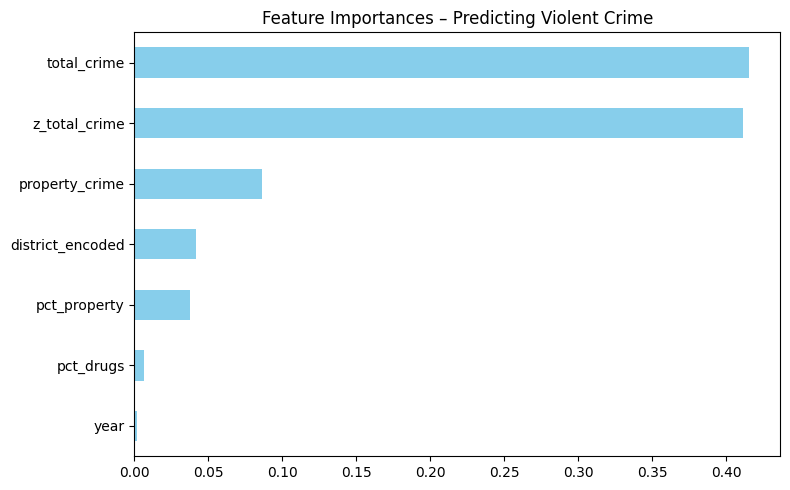

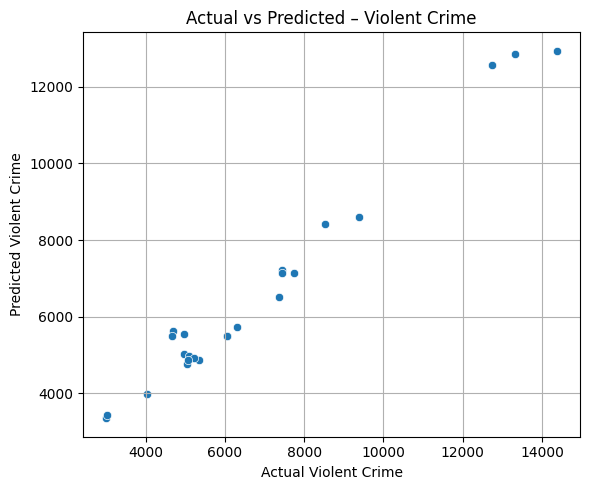

Model saved to model/violent_crime_predictor.pkl


In [14]:


# -----------------------------------------------------------
# STEP 4 – MODELING: PREDICT VIOLENT CRIME (REGRESSION)
# -----------------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_pickle("data/berlin_crime_engineered.pkl")


le = LabelEncoder()
df['district_encoded'] = le.fit_transform(df['district'])


features = [
    'year', 'district_encoded', 'total_crime', 'property_crime',
    'pct_drugs', 'pct_property', 'z_total_crime'
]
target = 'violent_crime'

X = df[features]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")


importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', figsize=(8, 5), color='skyblue')
plt.title("Feature Importances – Predicting Violent Crime")
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Violent Crime")
plt.ylabel("Predicted Violent Crime")
plt.title("Actual vs Predicted – Violent Crime")
plt.grid(True)
plt.tight_layout()
plt.show()


import joblib
joblib.dump(model, 'model/violent_crime_predictor.pkl')
print("Model saved to model/violent_crime_predictor.pkl")


